# Robot Control WS22/23
## 3R Roboter

Date:    **23.12.2022** \
Author:  **Kaufmann Stefan**


In [ ]:
"""
Date: 20.12.2022
Author: Kaufmann Stefan

Robot Control - Simulation 3R Roboter 
"""

import numpy as np
import sympy as sym
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin
#sym.init_printing()
from IPython.display import display


# 2. Modellbildung

![Alt text](fig/3R_Manipulator.png)



$
J = 
\begin{bmatrix}
J_{v} \\
J_{\omega}
\end{bmatrix}
$ mit 
$J = 
\begin{bmatrix}
\dot{x} \\ \dot{y} \\ \dot{z} \\
\dot{\omega_{x}} \\ \dot{\omega_{y}} \\ \dot{\omega_{z}} 
\end{bmatrix}$


In [ ]:
from Kinematik_3R import *
# Den Sourcecode finden Sie unter Kinematik_3R.py

''' Jacobimatrix '''
# zum Abspielen eingach die gewünsche Variable entkommentieren

#Jv_1
#Jv_2
display(Jv_3)

#Jw_1
#Jw_2
display(Jw_3)


In [ ]:
''' Kinetische Energie und Massenmatrix '''

display(D)

In [ ]:
''' Christoffel Symbole'''
display(C)

# qd  = erste Zeitableitung des Gelenkes
# qdd = zweite Zeitableitung des Gelenkes

In [ ]:
''' mechanische Teilsystem '''
tau = sym.simplify(D*qdd + C*qd + gv.T)
display(tau)
#sym.simplify(tau)

In [ ]:
'''Erweitertes System '''

display(M)



#B+R+C

# 3. Kinematik



In [ ]:
'''Vorwärtskinematik'''
import Animation as anim
import numpy as np
from numpy import cos, sin
from scipy.optimize import fsolve
import Parameter as param


def T0e(q):
    q1,q2,q3 = q[0],q[1],q[2]

    T = np.array([  param.l1*cos(q1) + param.l2*cos(q1 + q2) + param.l3*cos(q1 + q2 + q3) ,
                    param.l1*sin(q1) + param.l2*sin(q1 + q2) + param.l3*sin(q1 + q2 + q3) ,
                                                                                       0  ])    
    return T

# Winkelstellungen hier Eintragen
q = [-np.pi*3/5, np.pi*1/3, np.pi*1/3]

display(T0e(q))

t_sim = np.linspace(1, 1)                       # Für die Animation
anim.plot(q[0]*t_sim,q[1]*t_sim,q[2]*t_sim,0.1) # Animation


In [ ]:
'''Inverse Kinematik'''

def T0e(q):
    # Position welche Angefahren werden soll
    x,y,z = 1.5, 1.5, 0
    q1,q2,q3 = q[0],q[1],q[2]

    T = np.array([  param.l1*cos(q1) + param.l2*cos(q1 + q2) + param.l3*cos(q1 + q2 + q3) -x,
                    param.l1*sin(q1) + param.l2*sin(q1 + q2) + param.l3*sin(q1 + q2 + q3) -y,
                                                                                       0 -z ])    
    return T


root = fsolve(T0e, [0,0,0] )
   

for i in range(3):
    while abs(root[i]) > 2*np.pi:
        if root[i] > 0:
            root[i] -= (2*np.pi)
        else: root[i] += (2*np.pi)
display(root)


anim.plot(root[0]*t_sim,root[1]*t_sim,root[2]*t_sim,0.1)


### analytische Jacobimatrix und dessen Zeitableitung

$
J_{a}(q) = 
\begin{bmatrix}
I & 0 \\
0 & B^{-1}(\alpha)
\end{bmatrix}
J(q)
$

In [ ]:
# Analytische Jacobimatrix
display(Ja)

# Erste Zeitableitung
display(Ja_diff)

# Peseudoinverse 
display(Jat_inv)



# 4. Simulation

In [ ]:
import Animation as anim
import numpy as np
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin
#from Vorsteuerung import *







x0=[-np.pi/2*0,0,0,  0,0,0]       # x0 = [q1,q2,q3,qd1,qd2,qd3]

# define the discretization points
t_start = 0
t_stop = 10
dt = 1e-1

t_sim = np.linspace(t_start, t_stop, int((t_stop - t_start) / dt + 1))


# Define the controller
class Controller:
  def __init__(self,u,t):   
    #from Vorsteuerung import flat_output
    self.ctr = 'nix'
    self.u  = u
    self.t  = t

u=[0,0,0]

controller = Controller(u,t_sim)

#Wrapper für rechte Seite der Differentialgleichung
rhs=lambda t,x:model_nlin(t,x,controller)
    
solOde = solve_ivp(rhs,                  #zu simulierendes Modell
                    [t_start,t_stop],    #Zeitspanne für Simulation
                    x0,                  #Anfangszustand 
                    t_eval=t_sim,        #Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6  #Toleranzen
                    )


plt.plot(solOde.t, solOde.y[0]*180/np.pi, 'b', label='q_1')
plt.plot(solOde.t, solOde.y[1]*180/np.pi, 'g', label='q_2')
plt.plot(solOde.t, solOde.y[2]*180/np.pi, 'r', label='q_3')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('q1(t), q2(t), q3(t)')
plt.grid()
plt.show()

anim.plot(solOde.y[0],solOde.y[1],solOde.y[2],dt)

# 5. Reglerentwurf
- Entwurf einer Position- / Kraftregelung
- Simulation und graphische Darstellung

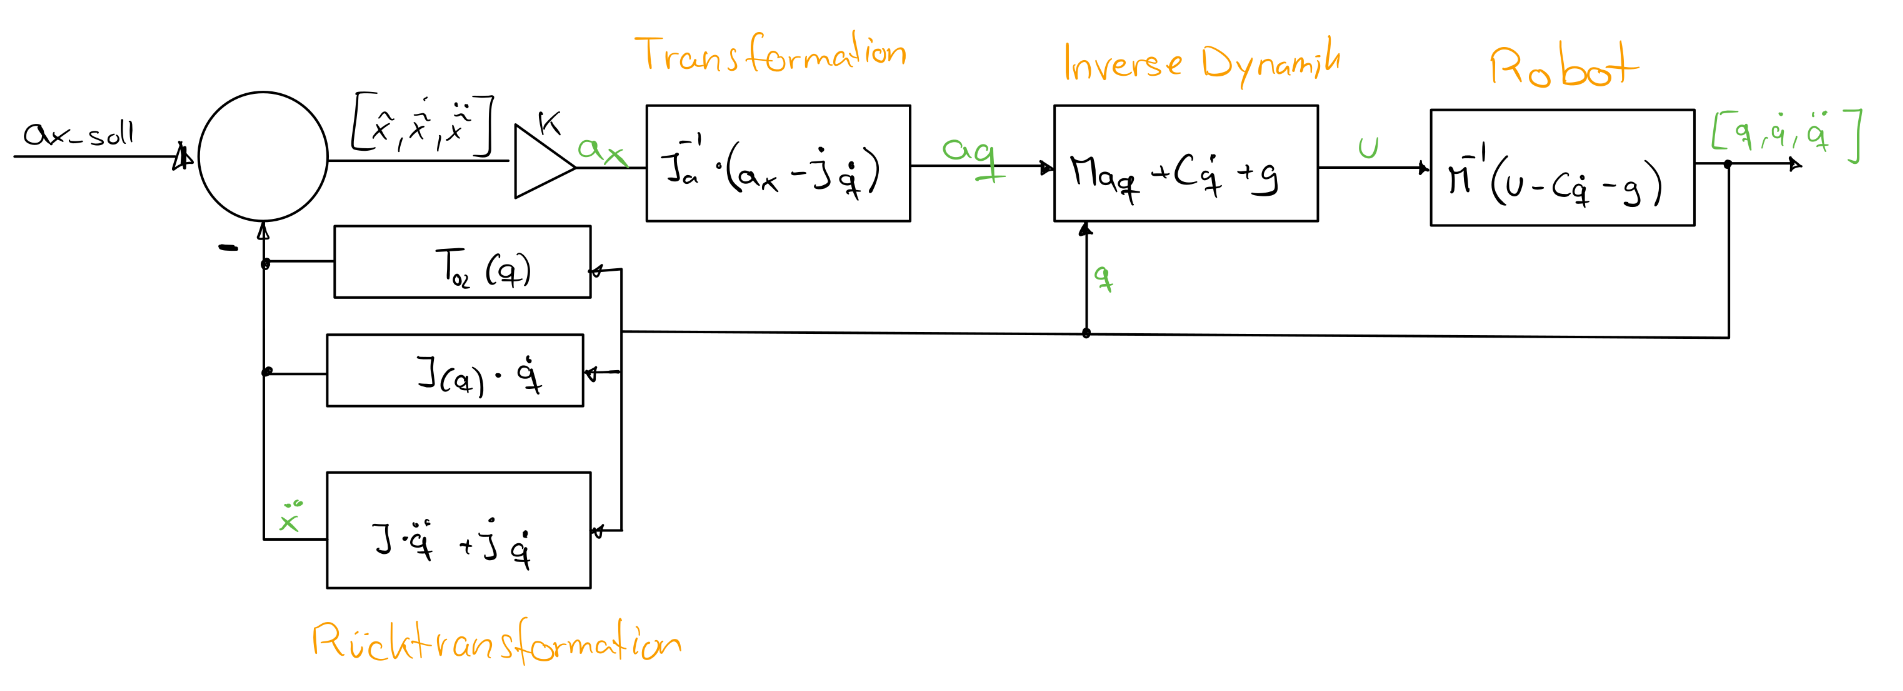

In [1]:
'''
Inverse Kinematik zur Überprüfung der Start und Zielposition
'''
import numpy as np
from numpy import cos, sin
from scipy.optimize import fsolve
import Parameter as param

def T0e(q,x,y,z=0, eps=1e-1):
    # Position welche Angefahren werden soll   
    
    q1,q2,q3 = q[0],q[1],q[2]

    T = np.array([  param.l1*cos(q1) + param.l2*cos(q1 + q2) + param.l3*cos(q1 + q2 + q3) -x+eps,
                    param.l1*sin(q1) + param.l2*sin(q1 + q2) + param.l3*sin(q1 + q2 + q3) -y,
                                                                                       0 -z ])    
    return T

def minimieren(root):
    for i in range(3):
     while abs(root[i]) > 2*np.pi:
        if root[i] > 0:
            root[i] -= (2*np.pi)
        else: root[i] += (2*np.pi)
    return root 

P0 = [1,-1,5]
P1 = [1,1.5]

P0s = minimieren(fsolve(T0e, [0,0,0], args=(P0[0], P0[1]) ))
P1s = minimieren(fsolve(T0e, [0,0,0], args=(P1[0], P1[1]) ))

display('Start',P0s)
display('Ziel', P1s)

'Start'

array([ 0.44099416, -1.79639977, -0.66666632])

'Ziel'

array([ 2.05228588, -1.57085868, -0.17537299])

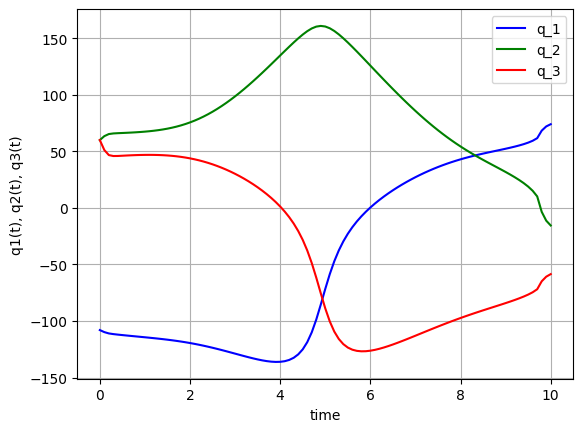

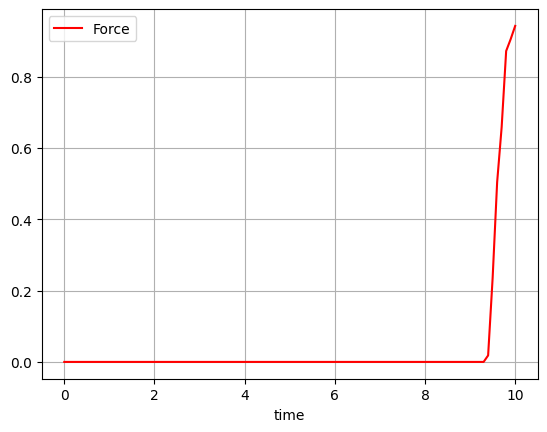

In [4]:
#%load_ext autoreload
#%autoreload 2


import Animation as anim
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin
from Vorsteuerung import *




# x0 = [q1,q2,q3,qd1,qd2,qd3]
# Definieren der Start und Zielposition im Arbeitsraum
phi,y = np.array([0,0]), np.array([-1.5,1.5])

#definition der Ausgangskonfiguration des Roboters
x0=[-np.pi*3/5, np.pi*1/3, np.pi*1/3, 0,0,0, 0,0,0, 0]     # [q1,q2,q3, qd1, qd2, qd3, qdd1, qdd2, qdd3, F]  


# define the discretization points
t_start = 0
t_stop = 10
dt = 1e-1

t_sim = np.linspace(t_start, t_stop, int((t_stop - t_start) / dt + 1))


# Define the controller
class Controller:
  def __init__(self,u,t_sim):    
    # Positionsregelung
    self.w     =  np.array([20*e-2,20])                                  # Reglerverstärung für jedes Gelenk      
    self.ctr   = 'multivariable'                                     # Auswahl Reglertyp    
    self.k0    = np.array([[self.w[0]**2, 0],[0, self.w[1]**2]])
    self.k1    = np.array([[2*self.w[0], 0],[0, 2*self.w[1]]])    
    self.ax    = u                                                   # u = [y,phi, yd, phid, ydd, phidd] 
    # Kraftregelung
    self.kf    = 20                                                   # Federkonstante
    self.xw    = 1                                                   # x-Position bei der die äußere Kraft beginnen soll
    self.kb    = 10                                                  # Reglerverstärkung bf
    self.kd    = 10                                                  # Reglerverstärung
    self.f     = 1                                                   # Anpressdruck
    self.force = False  
    self.fq    = 0      
    self.fx    = 0                                       
    # Allgemein
    self.u     = [0,0,0]
    self.t     = t_sim
    

## Trajektorienplanung im Arbeitsraum
# Define the input vector
ax1 = flat_output(t_stop,t_sim,3,y[0],y[1])
ax2 = flat_output(t_stop,t_sim,3,phi[0],phi[1])


ax= np.vstack((ax1[0,:],ax2[0,:],ax1[1,:],ax2[1,:],ax1[2,:],ax2[2,:]))

controller = Controller(ax,t_sim)

#Wrapper für rechte Seite der Differentialgleichung
rhs=lambda t,x:model_nlin(t,x,controller)
    
solOde = solve_ivp(rhs,                  #zu simulierendes Modell
                    [t_start,t_stop],    #Zeitspanne für Simulation
                    x0,                  #Anfangszustand 
                    t_eval=t_sim,        #Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6  #Toleranzen
                    )


plt.plot(solOde.t, solOde.y[0]*180/np.pi, 'b', label='q_1')
plt.plot(solOde.t, solOde.y[1]*180/np.pi, 'g', label='q_2')
plt.plot(solOde.t, solOde.y[2]*180/np.pi, 'r', label='q_3')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('q1(t), q2(t), q3(t)')
plt.grid()
plt.show()

plt.plot(solOde.t, solOde.y[9], 'r', label='Force')
plt.legend(loc='best')
plt.xlabel('time')
plt.grid()
plt.show()

In [5]:
anim.plot(solOde.y[0],solOde.y[1],solOde.y[2],dt)

# Debug File

In [ ]:
from Model import *


x = [1,2,3,4,5,6]
ax = [1,1,0,0,0,0]

qx = [0,0,0,0,0,0]
q1 = x[0]
q2 = x[1]
q3 = x[2]

qxx = sym.Matrix.vstack(sym.Matrix(x[2:4]),sym.zeros(4,1))


x_soll =   np.array(ax_soll[0:2])
xd_soll =  np.array(ax_soll[2:4])
xdd_soll = np.array(ax_soll[4:6])




F = [1,0,0,0,0,0]
